In [1]:
import xarray as xr
import glob
import os
from sublimpy import utils
import numpy as np 

In [2]:
filepath = "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240213/"
files = glob.glob(os.path.join(filepath, "*.nc"))

In [3]:
# sort files and remove datasets before November
files = sorted(files)[3:] # should be [3:]

# Create the hourly dataset

In [ ]:
datasets = []
for fn in files:
    ds = xr.open_dataset(fn)
    datasets.append(ds)

In [ ]:
# THIS TAKES AN EXTREMELY LONG TIME TO RUN, ~8 Hours
# To make it run more quickly, just grab the variables you want
sos_ds = xr.concat(datasets, dim='time')

In [ ]:
sos_ds

In [ ]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

In [ ]:
sos_hourly_ds = sos_ds.resample(time='60Min').mean()

In [ ]:
sos_hourly_ds.to_netcdf('sos_hourly_ds.nc')

# Create the 5min dataset (include only eddy covariance latent heat flux measurements)

In [6]:
datasets = []
for fn in files:
    ds = xr.open_dataset(fn)
    vars_to_grab = []
    if 'w_h2o__3m_c' in ds:
        vars_to_grab.append('w_h2o__3m_c')
    if 'w_h2o__5m_c' in ds:
        vars_to_grab.append('w_h2o__5m_c')
    if 'w_h2o__10m_c' in ds:
        vars_to_grab.append('w_h2o__10m_c')
    if 'w_h2o__15m_c' in ds:
        vars_to_grab.append('w_h2o__15m_c')
    if 'w_h2o__20m_c' in ds:
        vars_to_grab.append('w_h2o__20m_c')

    ds = ds[vars_to_grab]
    datasets.append(ds)

In [9]:
# No longer need to do this: because of an update to xarray.concat as of Feb 7, 2023
# https://docs.xarray.dev/en/stable/whats-new.html#v2023-02-0-feb-7-2023
# sos_ds = utils.merge_datasets_with_different_variables(datasets, dim='time')
# the following call to xr.concat should work:

# THIS TAKES AN EXTREMELY LONG TIME TO RUN, ~8 Hours
sos_ds = xr.concat(datasets, dim='time')

In [10]:
sos_ds

<xarray.Dataset>
Dimensions:       (time: 66528)
Coordinates:
  * time          (time) datetime64[ns] 2022-11-01T00:02:30 ... 2023-06-19T23...
Data variables:
    w_h2o__3m_c   (time) float32 0.002551 0.002685 0.002699 ... 0.091 0.07282
    w_h2o__5m_c   (time) float32 0.002108 0.002533 0.001475 ... 0.08503 0.1094
    w_h2o__10m_c  (time) float32 -0.00172 0.0006438 0.0002256 ... 0.1264 0.1808
    w_h2o__15m_c  (time) float32 -0.001724 0.0007904 ... 0.06544 0.0625
    w_h2o__20m_c  (time) float32 -0.001655 -0.0005572 ... 0.1058 0.1341
Attributes:
    project:                   SOS
    history:                   Created: 2023-11-14 02:16:36 +0000\n
    NIDAS_version:             v1.2.1-8
    calibration_file_path:     /net/isf/isff/projects/SOS/ISFS/cal_files/$SIT...
    dataset:                   qc_geo_tiltcor
    dataset_description:       QC, winds in geographic, tilt corrected coordi...
    project_config:            /net/isf/isff/projects/SOS/ISFS/config/sos.xml;
    wind3d_horiz_coordinates:  geographic
    file_length_seconds:       86400
    wind3d_horiz_rotation:     1
    wind3d_tilt_correction:    1

In [11]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

In [21]:
sos_ds.to_netcdf('sos_5min_lhflux_ds.nc')

# Check that the cumulative sublimation measurements look right.

In [13]:
from metpy.constants import density_water

In [15]:
sos_ds_mm = sos_ds*5*60/density_water.magnitude

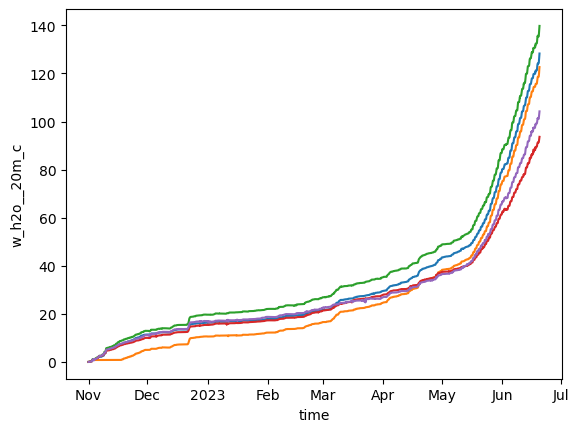

In [19]:
sos_ds_mm['w_h2o__3m_c'].cumsum().plot()
sos_ds_mm['w_h2o__5m_c'].cumsum().plot()
sos_ds_mm['w_h2o__10m_c'].cumsum().plot()
sos_ds_mm['w_h2o__15m_c'].cumsum().plot()
sos_ds_mm['w_h2o__20m_c'].cumsum().plot()